In [1]:
import scanpy as sc
import pycisTopic
from pycisTopic.cistopic_class import *
import pickle
import os
import pickle


In [2]:
cellltype = 'PFC_PFC_GABA'
ctname = 'PFC_GABA'

In [3]:
# Process the anndata object of 
def pre_process_anndata(input_file, output_file):
    # Filter cells based on quality control metrics
    adata_sc = sc.read_h5ad(input_file)
    adata_sc.layers['counts']
    adata_sc_raw = adata_sc.copy()
    adata_sc_raw.X = adata_sc.layers['counts'].copy()
    adata_sc.raw = adata_sc_raw
    adata_sc.obs['condition'] = ("M"+adata_sc.obs['status'].astype(str)).astype('category')
    adata_sc.obs['GEX:condition'] = adata_sc.obs['condition'].astype('category')
    adata_sc.write_h5ad(
        output_file
    )
    return adata_sc

In [4]:
adata_sc = pre_process_anndata(
    input_file=f'/data1st2/junyi/output/atac0416/subset/region_nt/{ctname}_sc.h5ad',
    output_file=f'/data1st2/junyi/output/atac0416/subset/region_nt/{cellltype}_sc.h5ad'
)

In [5]:

models = pickle.load(
    open(f"/data1st2/junyi/output/atac0416/cistopic/cistopic_{cellltype}_models.pkl", "rb")
)

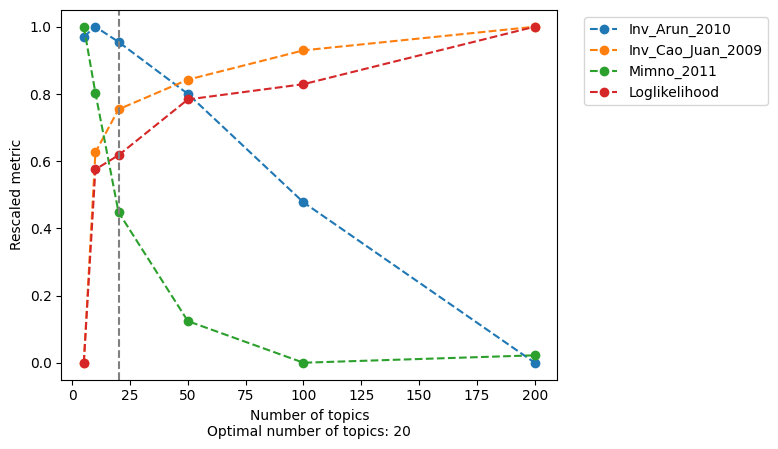

In [6]:
from pycisTopic.lda_models import evaluate_models
model = evaluate_models(
    models,
    min_topics_coh=0,
    select_model = 20,
    return_model = True
)


In [7]:
model

In [8]:
pycis_topic_obj = pickle.load(
    open(f"/data1st2/junyi/output/atac0416/cistopic/cistopic_{cellltype}.pkl", "rb")
)

In [9]:
pycis_topic_obj.add_LDA_model(model)


In [10]:
pickle.dump(
    pycis_topic_obj,
    open(os.path.join('/data1st2/junyi/output/atac0416/cistopic', f"cistopic_{cellltype}.pkl"), "wb")
)


In [11]:
from pycisTopic.clust_vis import (
    find_clusters,
    run_umap,
    run_tsne,
    plot_metadata,
    plot_topic,
    cell_topic_heatmap
)

In [12]:
find_clusters(
    pycis_topic_obj,
    target  = 'cell',
    k = 10,
    res = [0.6, 1.2, 3],
    prefix = 'pycisTopic_',
    scale = True,
    split_pattern = '-'
)


2025-06-10 15:16:28,985 cisTopic     INFO     Finding neighbours


In [13]:
run_umap(
    pycis_topic_obj,
    target  = 'cell', scale=True)


2025-06-10 15:16:31,214 cisTopic     INFO     Running UMAP


/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


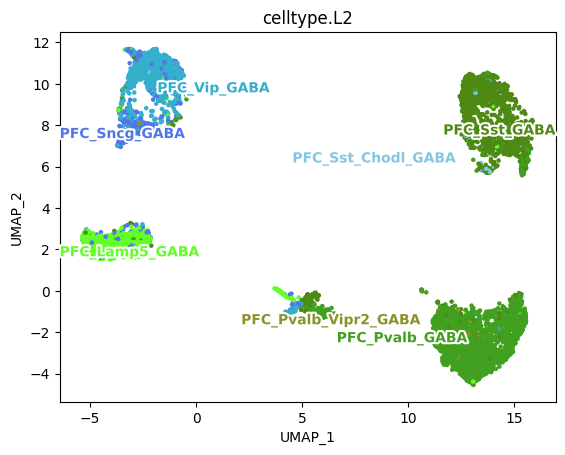

In [14]:
plot_metadata(
    pycis_topic_obj,
    reduction_name='UMAP',
    variables=['celltype.L2'],
    target='cell', num_columns=1,
    text_size=10,
    dot_size=5)


In [15]:
# annot_dict = {}
# for resolution in [0.6, 1.2, 3]:
#     annot_dict[f"pycisTopic_leiden_10_{resolution}"] = {}
#     for cluster in set(pycis_topic_obj.cell_data[f"pycisTopic_leiden_10_{resolution}"]):
#         counts = pycis_topic_obj.cell_data.loc[
#             pycis_topic_obj.cell_data.loc[pycis_topic_obj.cell_data[f"pycisTopic_leiden_10_{resolution}"] == cluster].index,
#             "celltype.L2"].value_counts()
#         annot_dict[f"pycisTopic_leiden_10_{resolution}"][cluster] = f"{counts.index[counts.argmax()]}({cluster})"


In [16]:
# for resolution in [0.6, 1.2, 3]:
#     pycis_topic_obj.cell_data[f'pycisTopic_leiden_10_{resolution}'] = [
#         annot_dict[f'pycisTopic_leiden_10_{resolution}'][x] for x in pycis_topic_obj.cell_data[f'pycisTopic_leiden_10_{resolution}'].tolist()
#     ]


In [17]:
# plot_metadata(
#     pycis_topic_obj,
#     reduction_name='UMAP',
#     variables=['celltype.L2', 'pycisTopic_leiden_10_0.6', 'pycisTopic_leiden_10_1.2', 'celltype.L3'],
#     target='cell', num_columns=4,
#     text_size=10,
#     dot_size=5)


In [18]:
# plot_topic(
#     pycis_topic_obj,
#     reduction_name = 'UMAP',
#     target = 'cell',
#     num_columns=5
# )


In [19]:
# if isinstance(pycis_topic_obj.cell_data.index, pd.MultiIndex):
#     pycis_topic_obj.cell_data = pycis_topic_obj.cell_data.reset_index()


In [20]:
# pycis_topic_obj.cell_data['celltype.L2'] = pycis_topic_obj.cell_data['celltype.L2'].astype('str')pycis_topic_obj.cell_data['celltype.L2'].astype('str').replace("Hippo_","")
pycis_topic_obj.cell_data['celltype.L2str'] = pycis_topic_obj.cell_data['celltype.L2'].astype('str').str.replace("Hippo_","")
pycis_topic_obj.cell_data['C'] = pycis_topic_obj.cell_data['condtion'].astype('str')

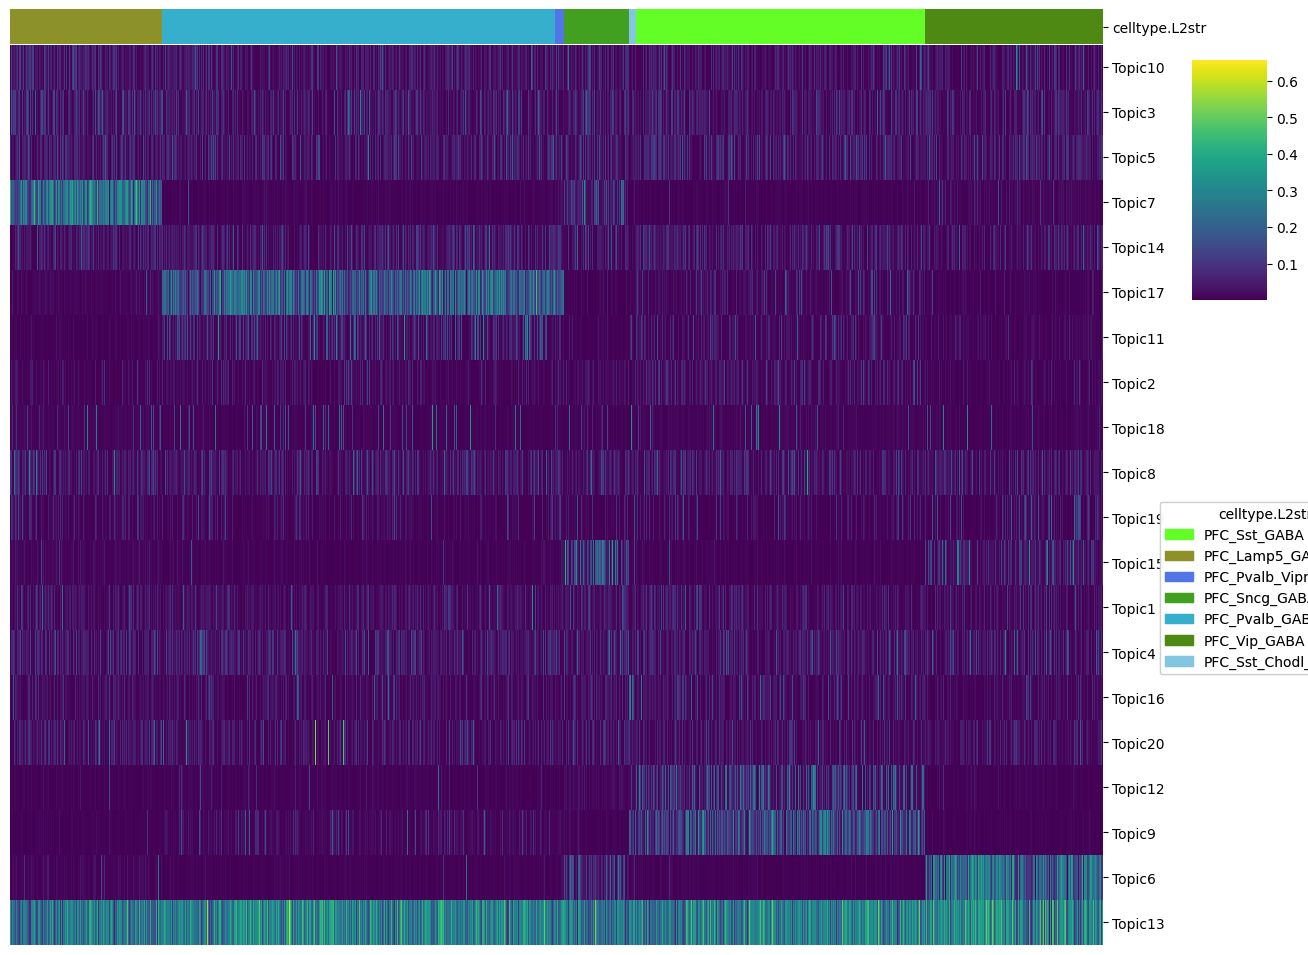

In [21]:
cell_topic_heatmap(
    pycis_topic_obj,
    variables = ['celltype.L2str'],
    scale = False,
    legend_loc_x = 0.98,
    legend_loc_y = -1.2,
    legend_dist_y = -1.5,
    figsize = (15, 12),
)


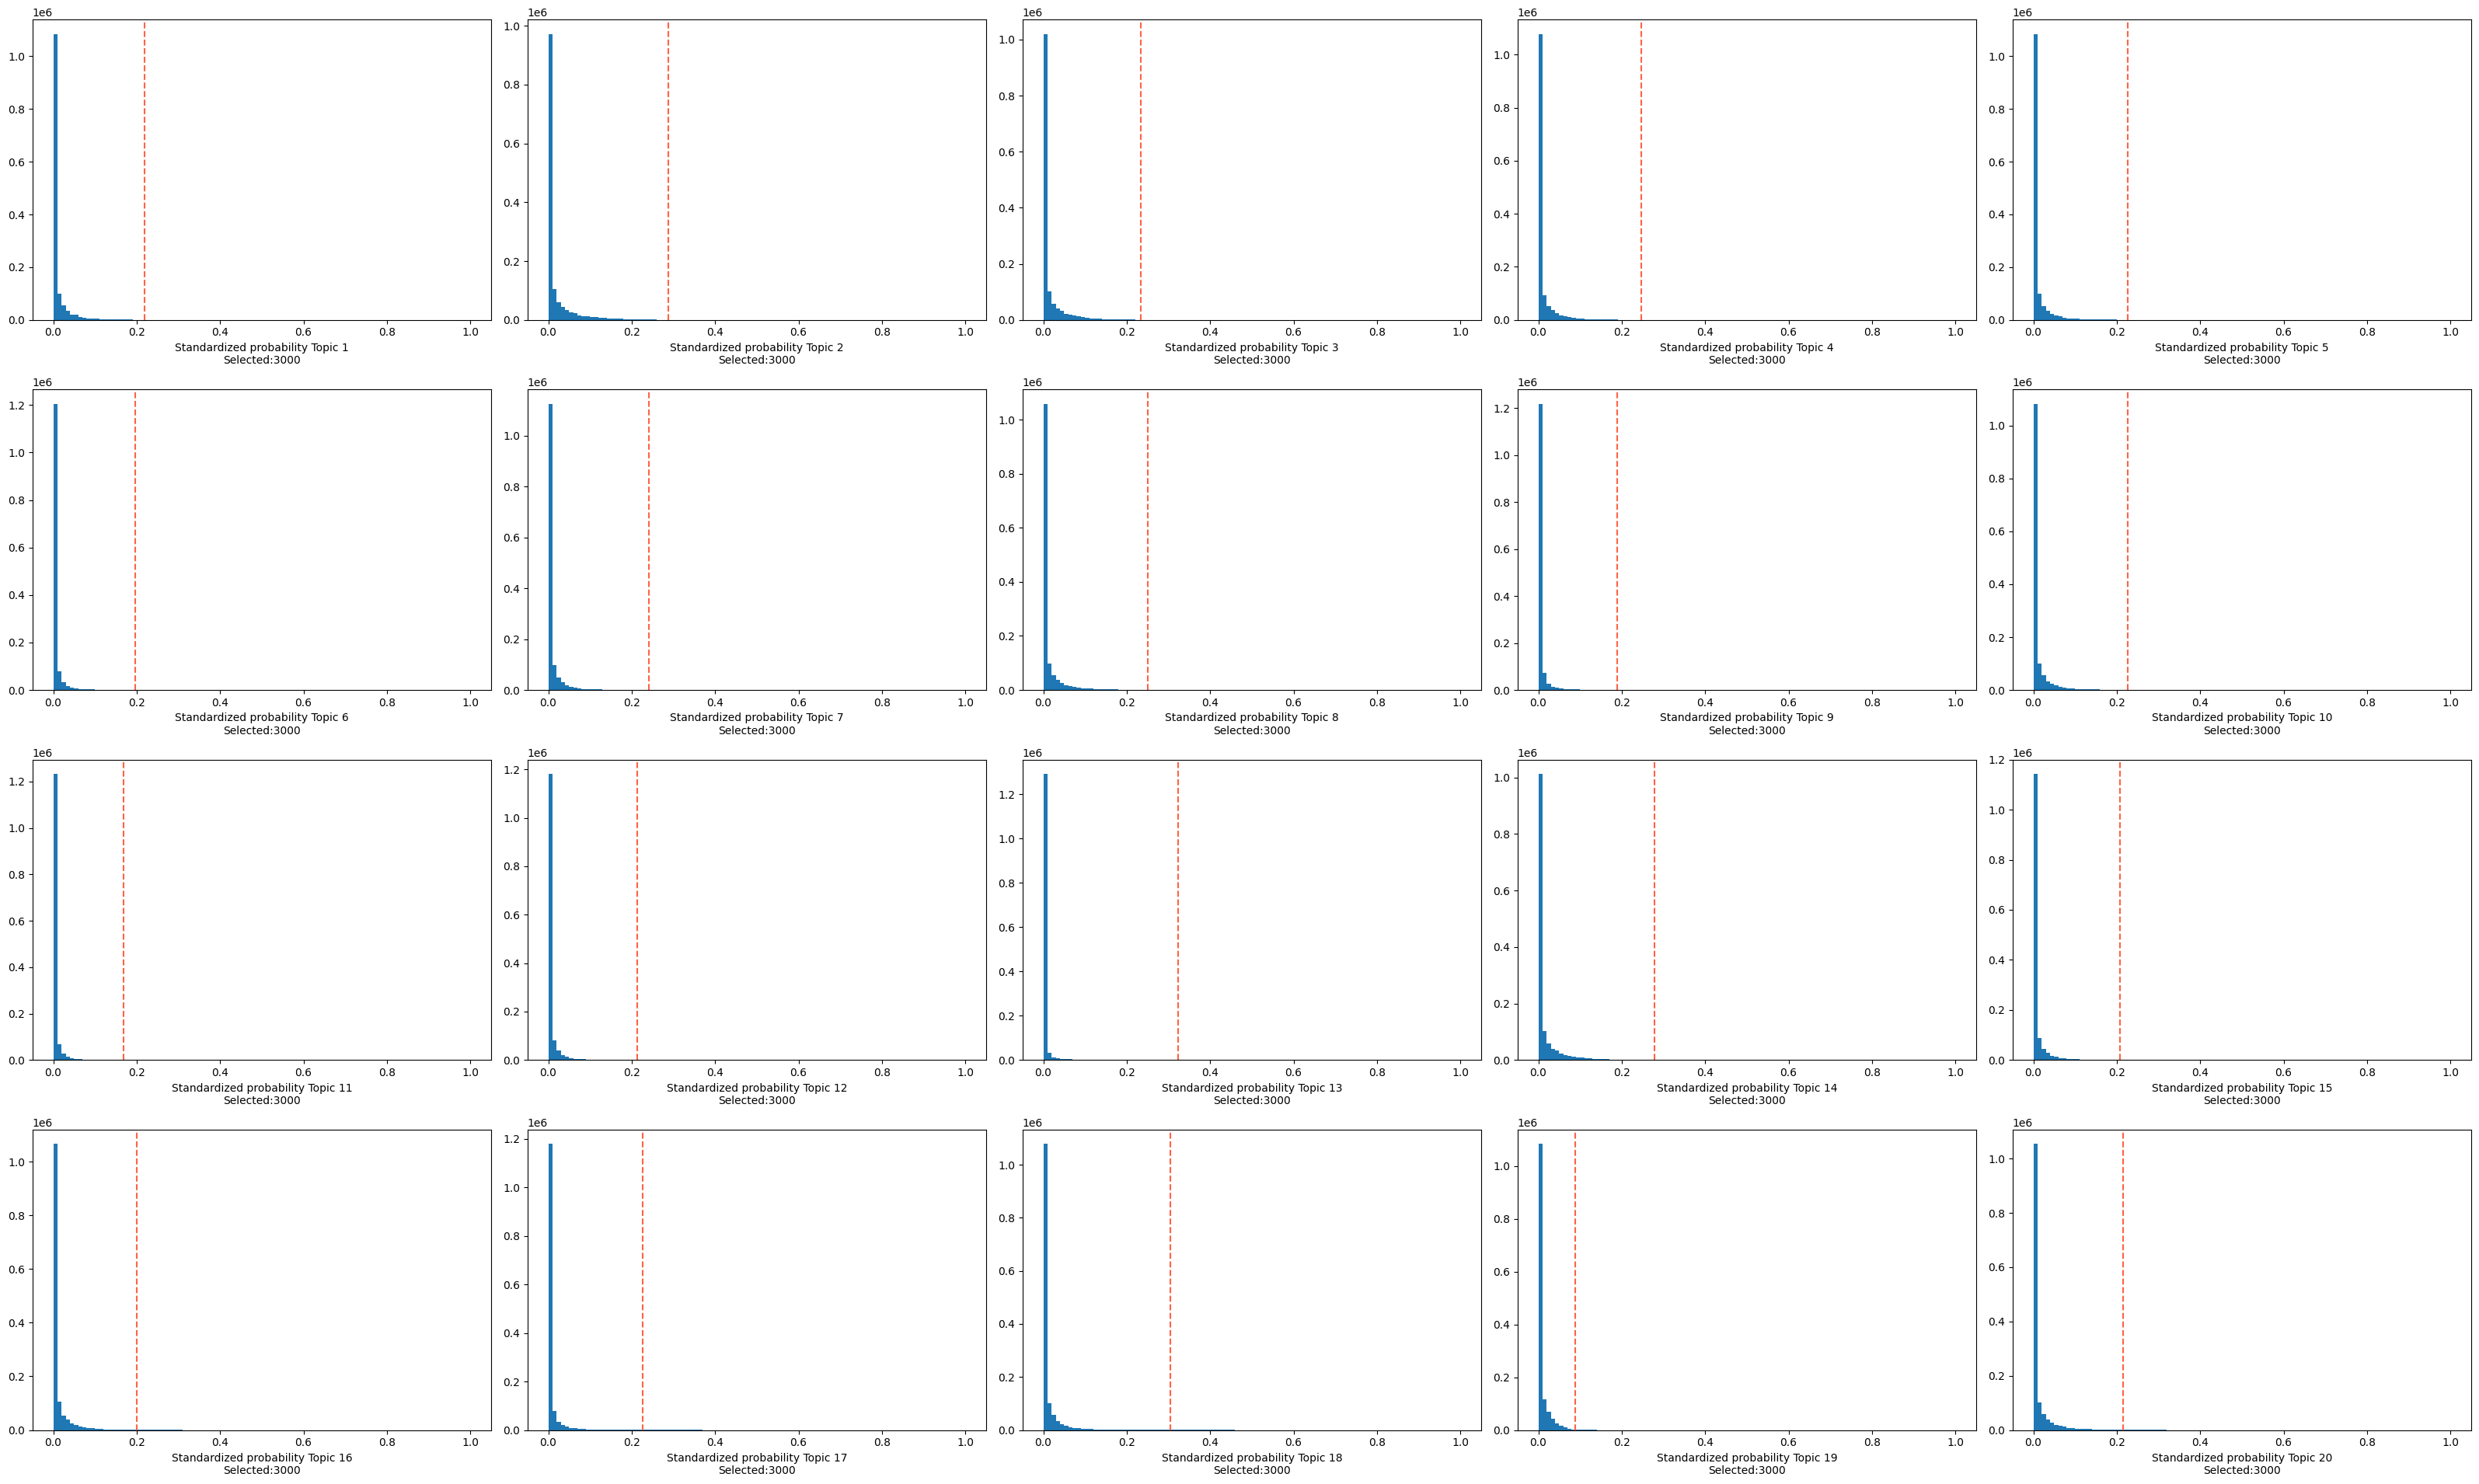

In [22]:
from pycisTopic.topic_binarization import binarize_topics
region_bin_topics_top_3k = binarize_topics(
    pycis_topic_obj, method='ntop', ntop = 3_000,
    plot=True, num_columns=5
)


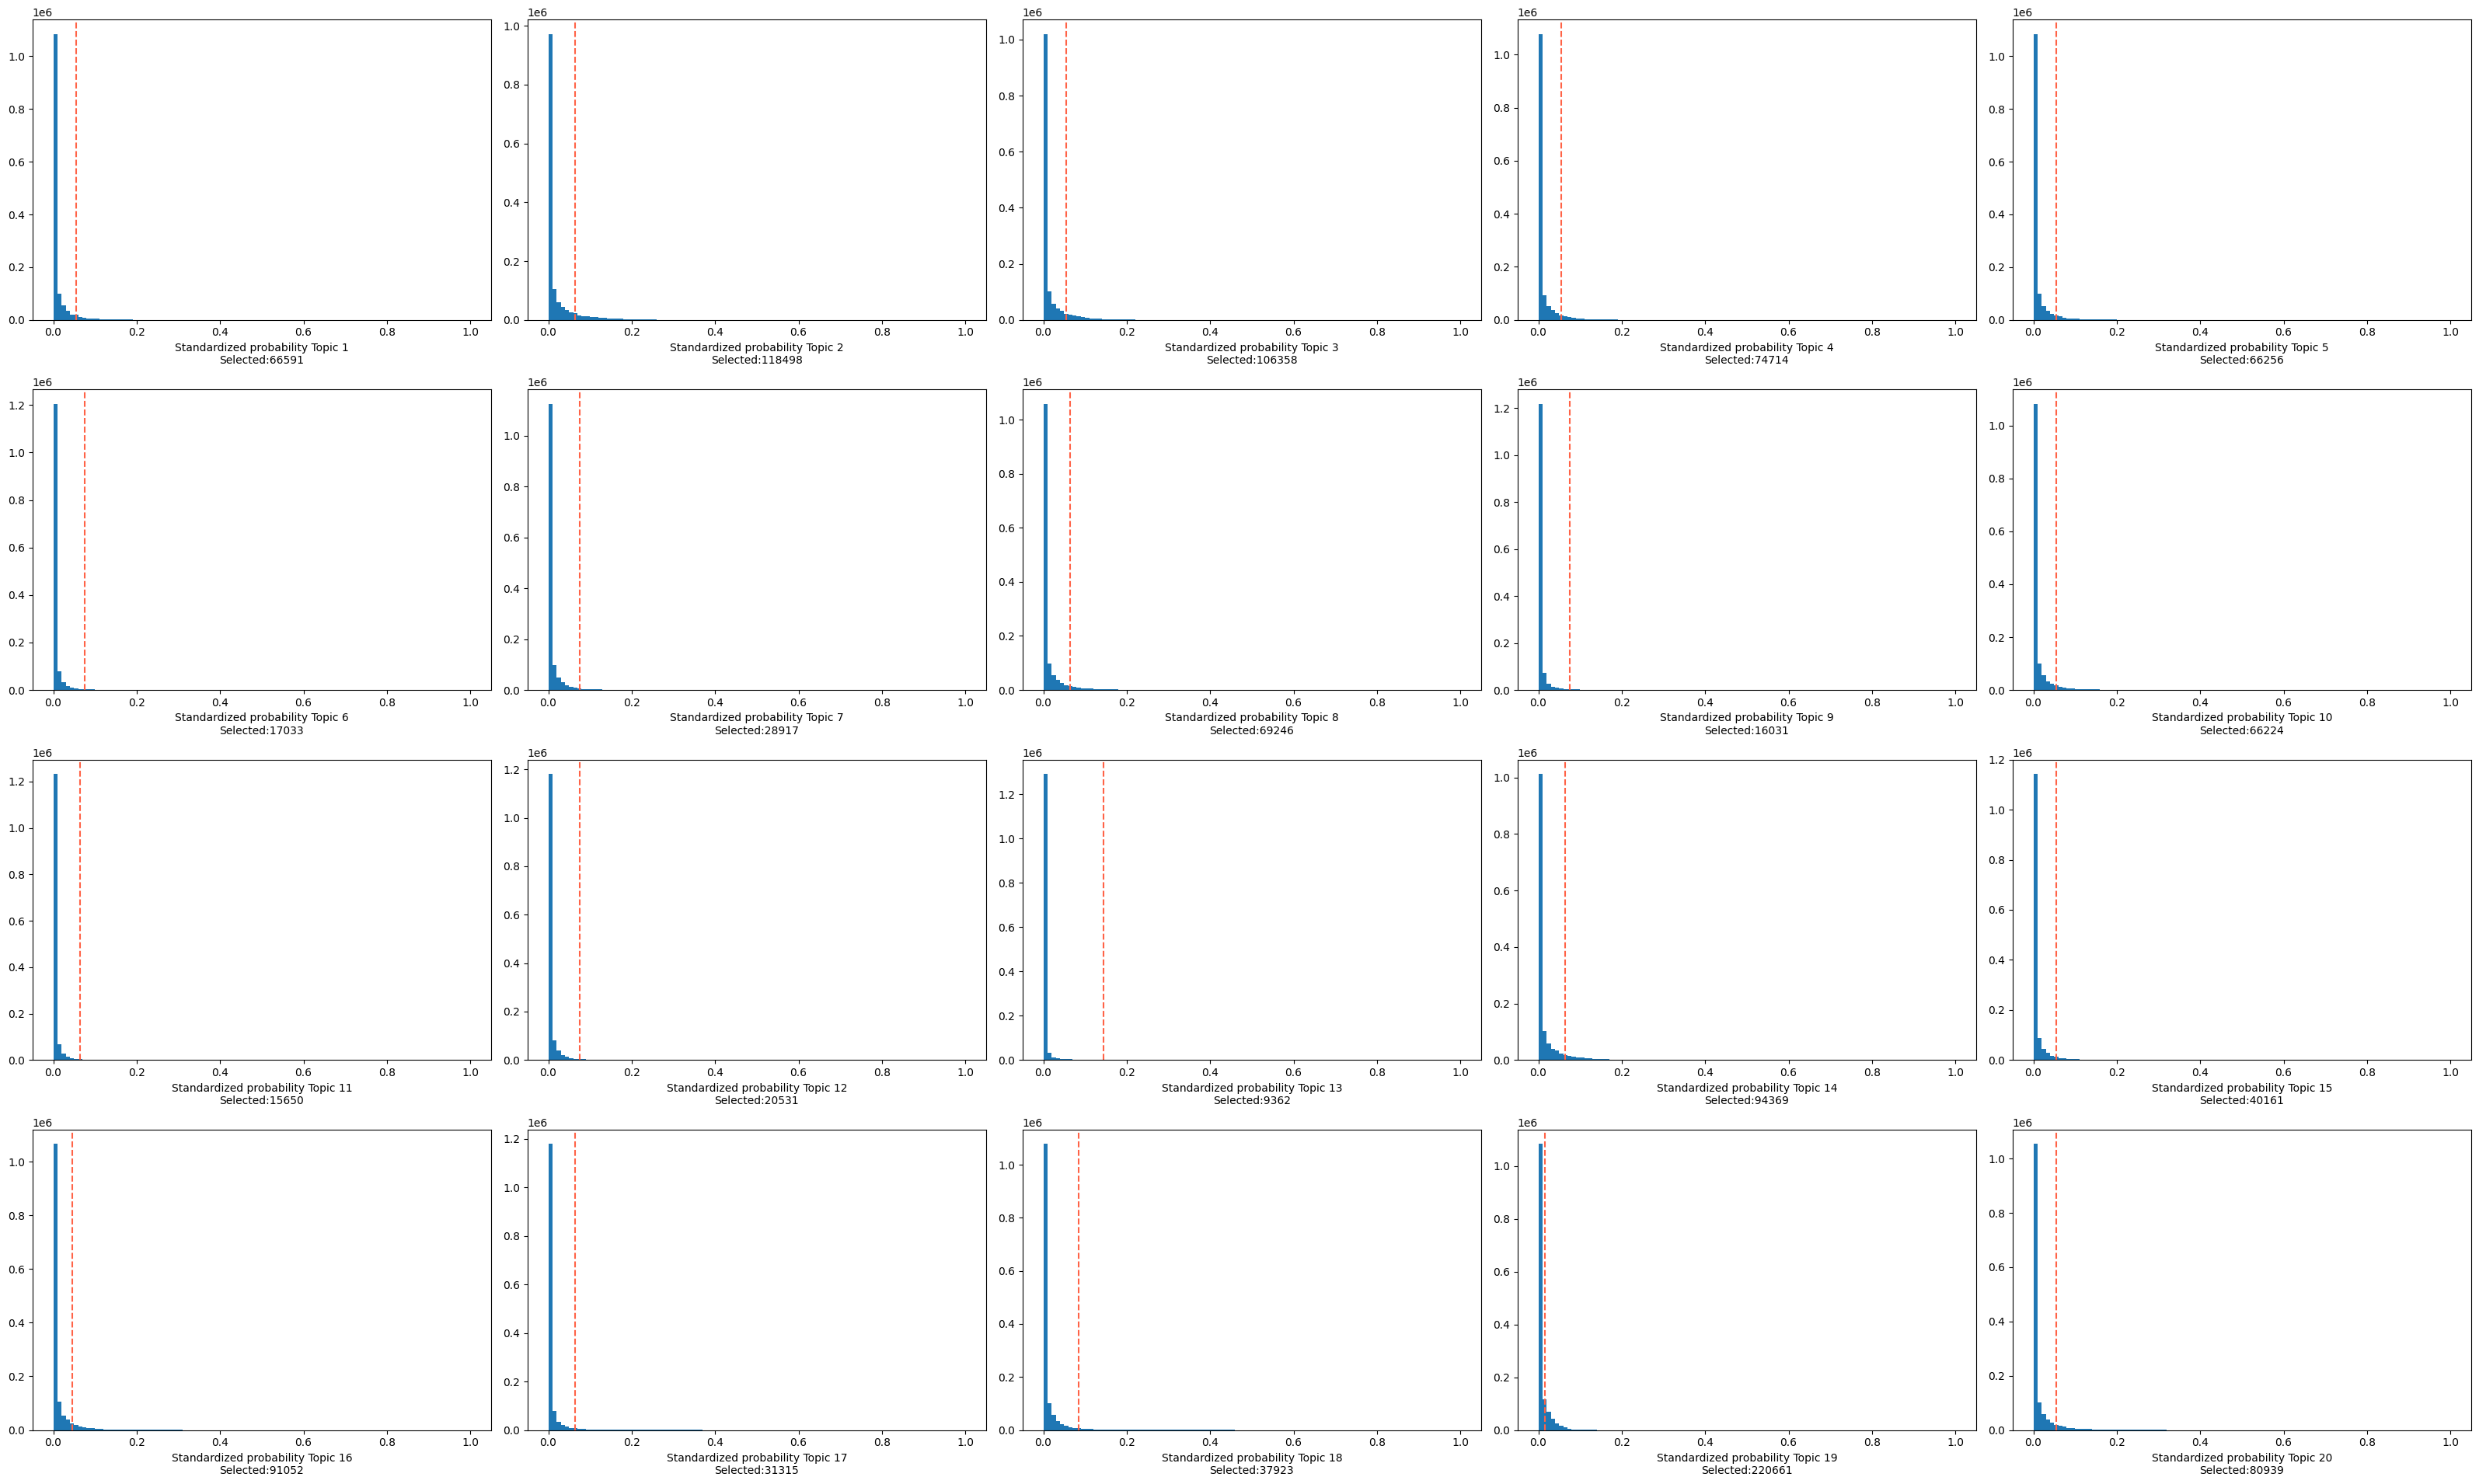

In [23]:
region_bin_topics_otsu = binarize_topics(
    pycis_topic_obj, method='otsu',
    plot=True, num_columns=5
)


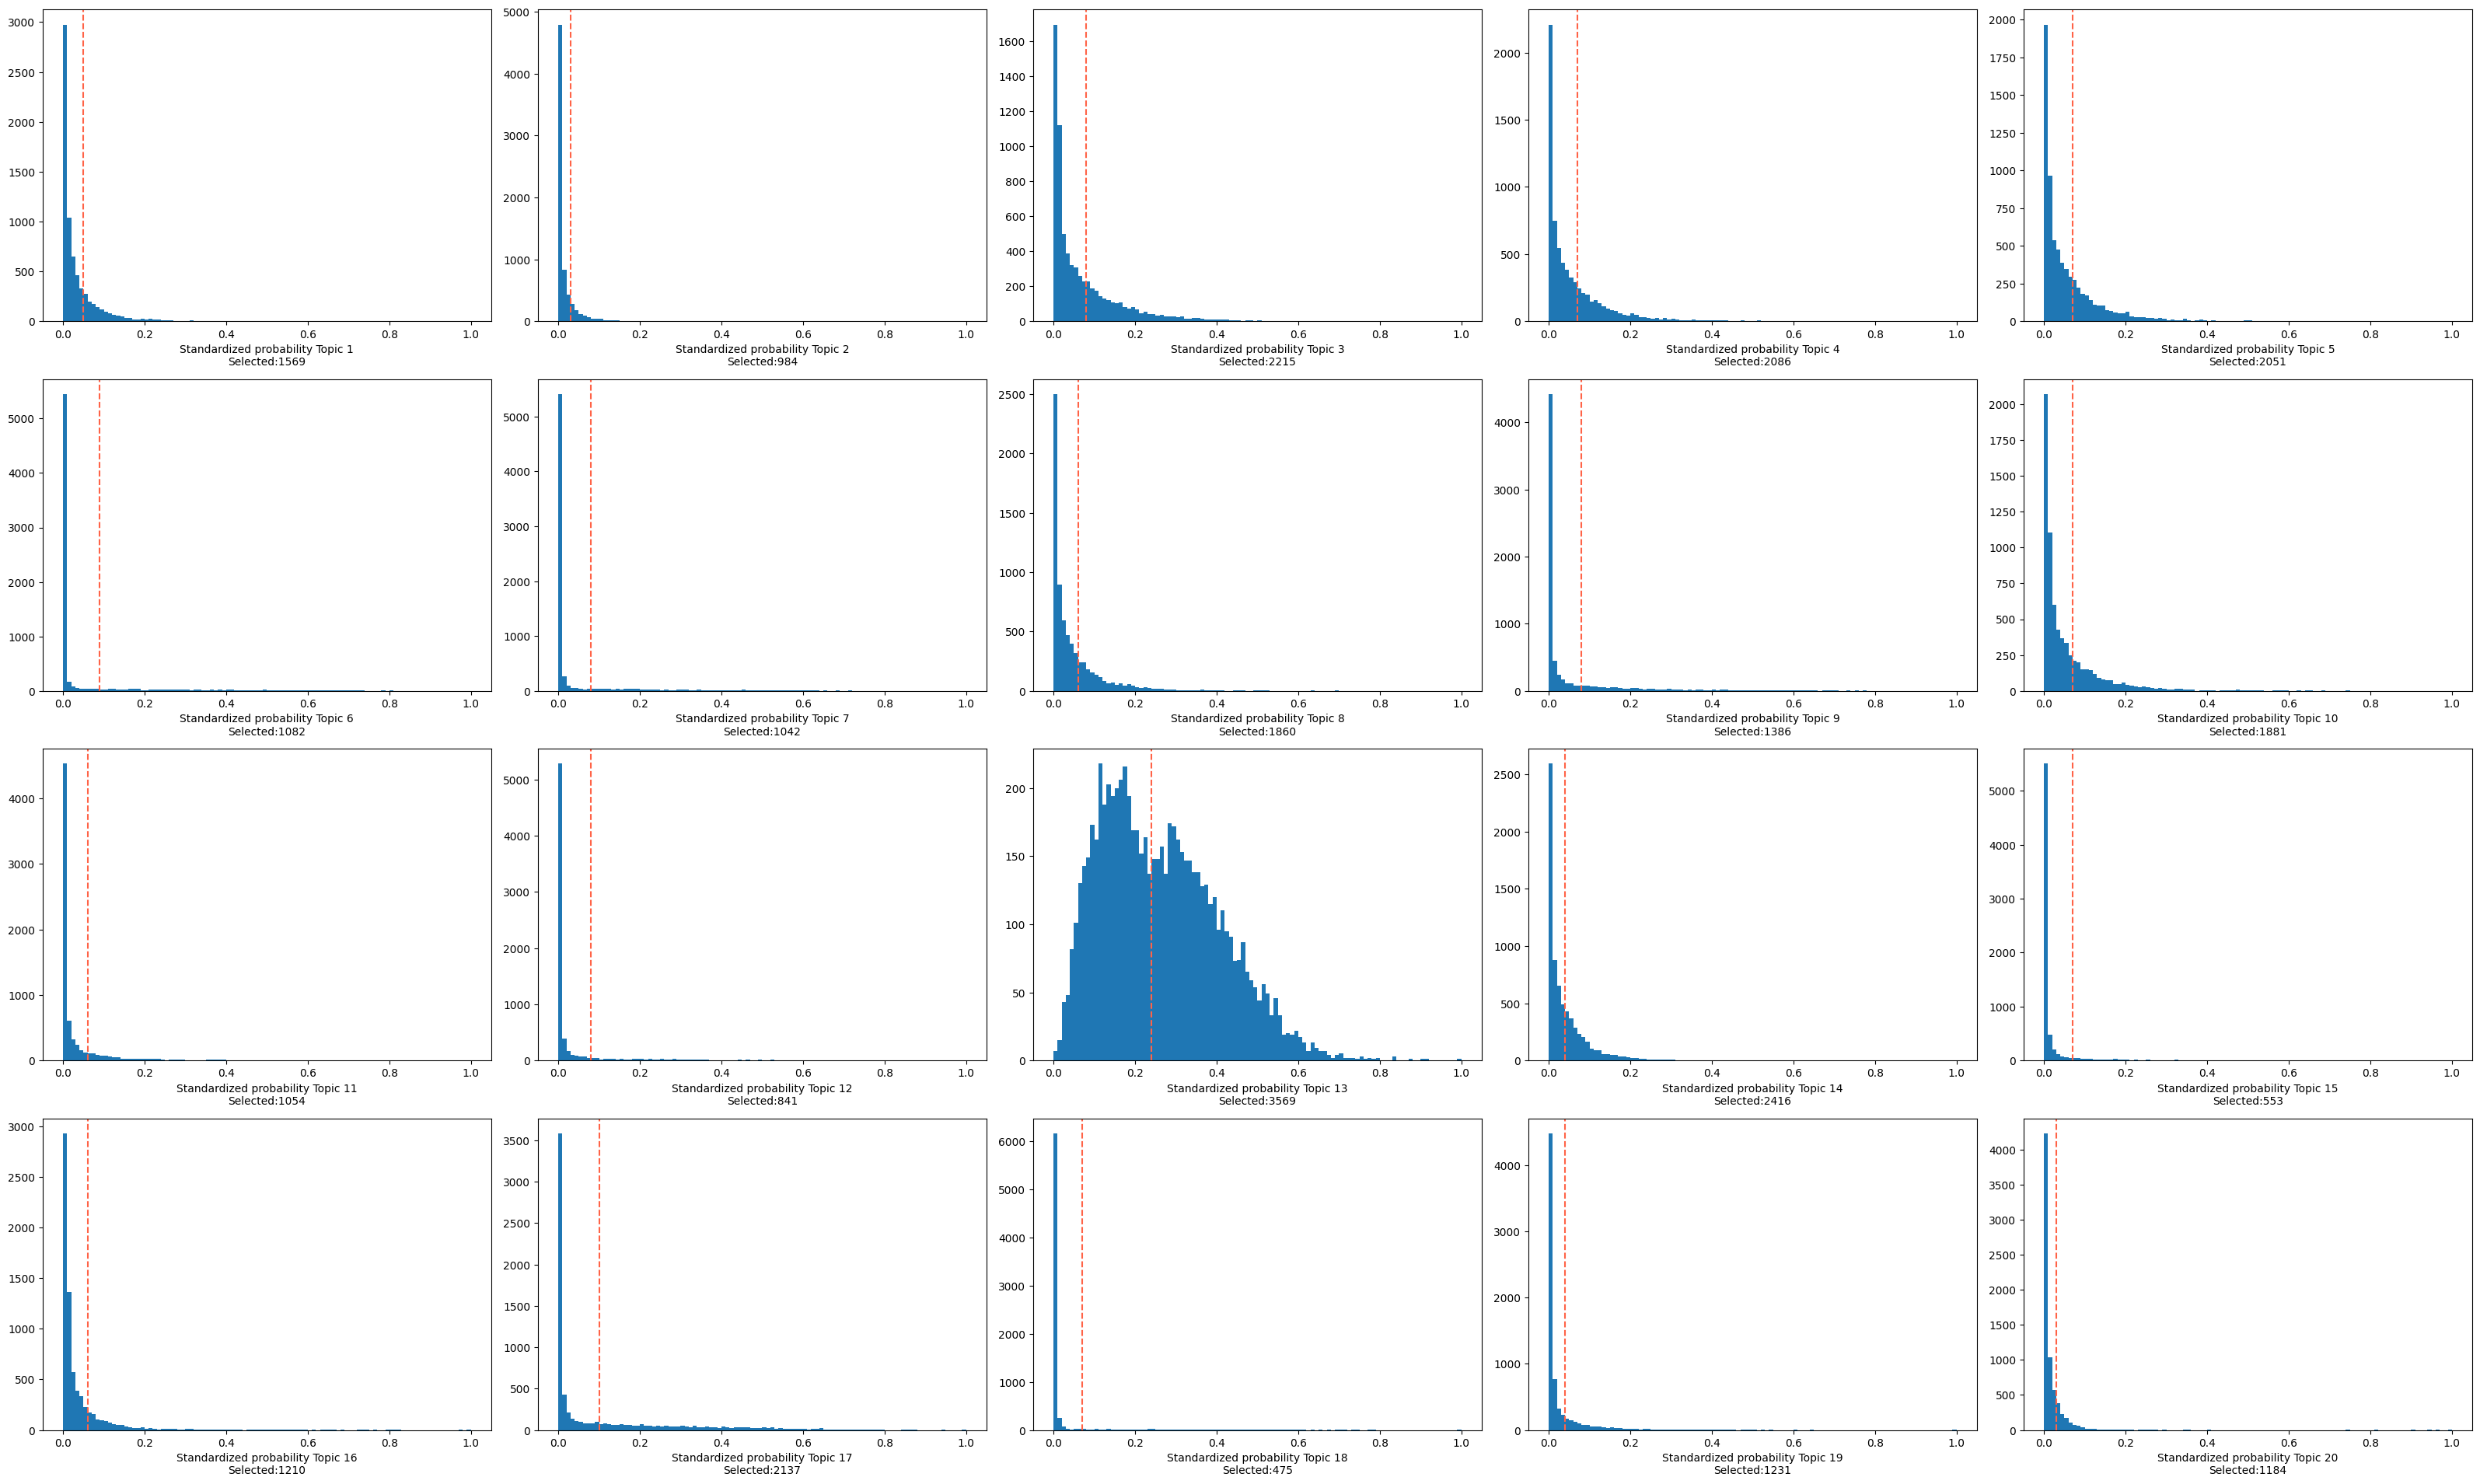

In [24]:
binarized_cell_topic = binarize_topics(
    pycis_topic_obj,
    target='cell',
    method='li',
    plot=True,
    num_columns=5, nbins=100)


In [25]:
from pycisTopic.topic_qc import compute_topic_metrics, plot_topic_qc, topic_annotation
import matplotlib.pyplot as plt
from pycisTopic.utils import fig2img


In [26]:
topic_qc_metrics = compute_topic_metrics(pycis_topic_obj)


In [27]:
fig_dict={}
fig_dict['CoherenceVSAssignments']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)


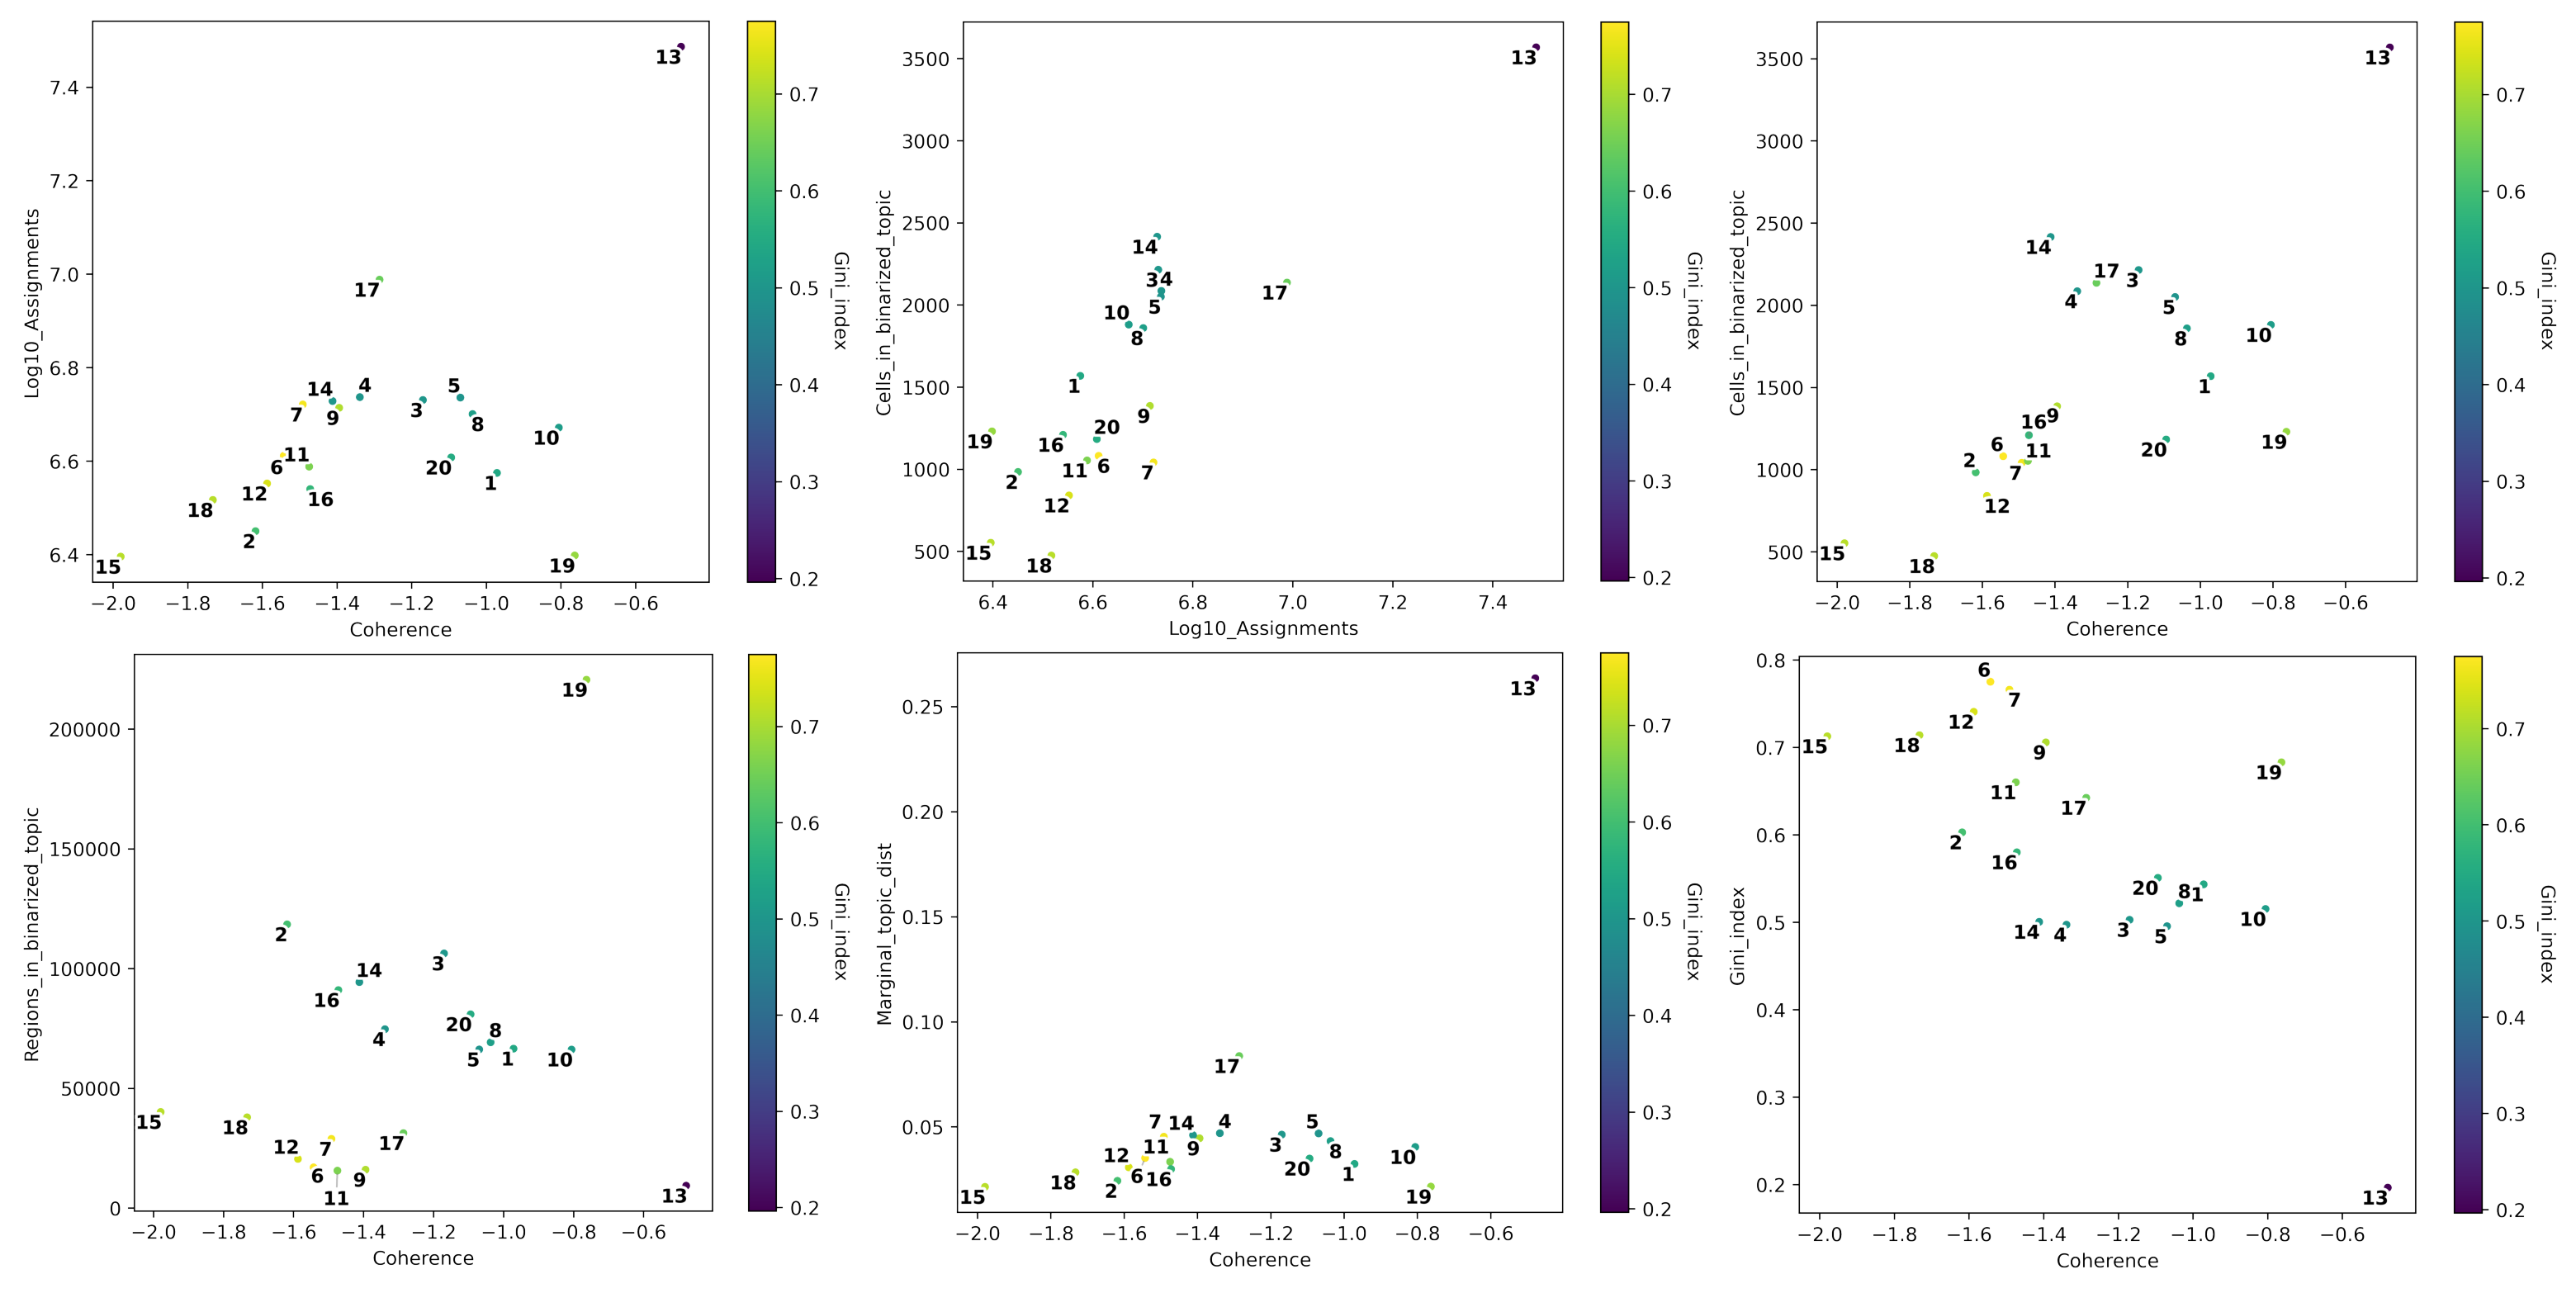

In [28]:
# Plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
plt.show()


In [29]:
topic_annot = topic_annotation(
    pycis_topic_obj,
    annot_var='celltype.L2',
    binarized_cell_topic=binarized_cell_topic,
    general_topic_thr = 0.2
)


/home/junyichen/anaconda3/envs/scenicplus/lib/python3.11/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: divide by zero encountered in scalar divide
  zstat = value / std


In [30]:
import os

out_dir = f'/data1st2/junyi/output/atac0416/cistopic/{cellltype}'

if not os.path.exists(out_dir):
    os.makedirs(out_dir, exist_ok=True)
if not os.path.exists(os.path.join(out_dir, "region_sets")):
    os.makedirs(os.path.join(out_dir, "region_sets"), exist_ok=True)


os.makedirs(os.path.join(out_dir, "region_sets"), exist_ok=True)
os.makedirs(os.path.join(out_dir, "region_sets", "Topics_otsu"), exist_ok=True)
os.makedirs(os.path.join(out_dir, "region_sets", "Topics_top_3k"), exist_ok=True)
os.makedirs(os.path.join(out_dir, "region_sets", "DARs"), exist_ok=True)



In [31]:
from pycisTopic.utils import region_names_to_coordinates


In [32]:
for topic in region_bin_topics_otsu:
    region_names_to_coordinates(
        region_bin_topics_otsu[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "Topics_otsu", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )


In [33]:
for topic in region_bin_topics_top_3k:
    region_names_to_coordinates(
        region_bin_topics_top_3k[topic].index
    ).sort_values(
        ["Chromosome", "Start", "End"]
    ).to_csv(
        os.path.join(out_dir, "region_sets", "Topics_top_3k", f"{topic}.bed"),
        sep = "\t",
        header = False, index = False
    )

In [34]:
scenic_dir = f'/data1st2/junyi/output/atac0416/scenic/{cellltype}'

In [35]:
df_dar= pd.read_csv(
    '/data2st1/junyi/output/atac0526/dar/region_nt/mementob_cr_annotated.csv')

In [36]:
df_dar_UP = df_dar.loc[
    (df_dar['ctname'] == ctname) & (df_dar['regulation'] == 'Up')
]
df_dar_bed = df_dar_UP.names.str.split(r'[:-]',expand=True)
df_dar_bed.iloc[:, 1] = df_dar_bed.iloc[:, 1].astype(int)
df_dar_bed.iloc[:, 2] = df_dar_bed.iloc[:, 2].astype(int)
df_dar_bed.sort_values(
    [0, 1, 2]
).to_csv(
    os.path.join(out_dir, "region_sets", "DARs", f"CUMS_Up.bed"),
    sep = "\t",
    header = False, index = False
)

/tmp/ipykernel_804165/3373426826.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_dar_bed.iloc[:, 1] = df_dar_bed.iloc[:, 1].astype(int)
/tmp/ipykernel_804165/3373426826.py:6: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_dar_bed.iloc[:, 2] = df_dar_bed.iloc[:, 2].astype(int)


In [37]:
df_dar_DOWN = df_dar.loc[
    (df_dar['ctname'] == ctname) & (df_dar['regulation'] == 'Down')
]
df_dar_bed = df_dar_DOWN.names.str.split(r'[:-]',expand=True)
df_dar_bed.iloc[:, 1] = df_dar_bed.iloc[:, 1].astype(int)
df_dar_bed.iloc[:, 2] = df_dar_bed.iloc[:, 2].astype(int)
df_dar_bed.sort_values(
    [0, 1, 2]
).to_csv(
    os.path.join(out_dir, "region_sets", "DARs", f"CUMS_Down.bed"),
    sep = "\t",
    header = False, index = False
)

/tmp/ipykernel_804165/2422891388.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_dar_bed.iloc[:, 1] = df_dar_bed.iloc[:, 1].astype(int)
/tmp/ipykernel_804165/2422891388.py:6: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_dar_bed.iloc[:, 2] = df_dar_bed.iloc[:, 2].astype(int)


In [38]:
!cd {scenic_dir}
!scenicplus init_snakemake --out_dir {scenic_dir}

/bin/bash: line 1: cd: /data1st2/junyi/output/atac0416/scenic/PFC_PFC_GABA: No such file or directory
2025-06-10 15:18:11,740 SCENIC+      INFO     Creating snakemake folder in: /data1st2/junyi/output/atac0416/scenic/PFC_PFC_GABA


input_data:  
  cisTopic_obj_fname: "/data1st2/junyi/output/atac0416/cistopic/cistopic_HIP_HIP_Glut.pkl"
  GEX_anndata_fname: "/data1st2/junyi/output/atac0416/subset/region_nt/HIP_HIP_Glut_sc.h5ad"
  region_set_folder: "/data1st2/junyi/output/atac0416/cistopic/HIP_HIP_Glut/region_sets/"
  ctx_db_fname: "/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather"
  dem_db_fname: "/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.scores.feather"
  path_to_motif_annotations: "/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl"

params_general:
  temp_dir: "/data1st2/junyi/output/atac0416/scenic/HIP_HIP_Glut/"
  n_cpu: 32

params_data_preparation:
  # Params for prepare_GEX_ACC
  is_multiome: False
  key_to_group_by: "celltype.L2"
  species: "mmusculus"
  biomart_host: "http://nov2020.archive.ensembl.org"

  species: "mus_musculus"


In [ ]:
import yaml

config = yaml.safe_load(
    open(
        os.path.join(scenic_dir,'Snakemake','config', "config.yaml"), "r"
    )
)

In [ ]:
scenic_dir

In [ ]:
# Update the config file with the new region sets
# input_data:  
#   cisTopic_obj_fname: "/data1st2/junyi/output/atac0416/cistopic/cistopic_HIP_HIP_Glut.pkl"
#   GEX_anndata_fname: "/data1st2/junyi/output/atac0416/subset/region_nt/HIP_HIP_Glut_sc.h5ad"
#   region_set_folder: "/data1st2/junyi/output/atac0416/cistopic/HIP_HIP_Glut/region_sets/"
#   ctx_db_fname: "/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather"
#   dem_db_fname: "/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.scores.feather"
#   path_to_motif_annotations: "/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl"

# params_general:
#   temp_dir: "/data1st2/junyi/output/atac0416/scenic/HIP_HIP_Glut/"
#   n_cpu: 32

# params_data_preparation:
#   # Params for prepare_GEX_ACC
#   is_multiome: False
#   key_to_group_by: "celltype.L2"
#   species: "mmusculus"
#   biomart_host: "http://nov2020.archive.ensembl.org"
#params_motif_enrichment
#   species: "mus_musculus"

config['input_data']['cisTopic_obj_fname'] = f"/data1st2/junyi/output/atac0416/cistopic/cistopic_{cellltype}.pkl"
config['input_data']['GEX_anndata_fname'] = f"/data1st2/junyi/output/atac0416/subset/region_nt/{cellltype}_sc.h5ad"
config['input_data']['region_set_folder'] = os.path.join(out_dir, "region_sets")
config['input_data']['ctx_db_fname'] = "/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.rankings.feather"
config['input_data']['dem_db_fname'] = "/data2st1/junyi/scenic/mouse/motif/mm10_screen_v10_clust.regions_vs_motifs.scores.feather"
config['input_data']['path_to_motif_annotations'] = "/data2st1/junyi/scenic/mouse/motif/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl"

config['params_general']['temp_dir'] = scenic_dir
config['params_general']['n_cpu'] = 32
config['params_data_preparation']['species'] = "mus_musculus"
config['params_data_preparation']['key_to_group_by'] = "celltype.L2"
config['params_data_preparation']['is_multiome'] = False
config['params_data_preparation']['biomart_host'] = "http://nov2020.archive.ensembl.org"
config['params_motif_enrichment']['species'] = "mus_musculus"

In [ ]:
config = yaml.dump(
    config,
    open(
        os.path.join(scenic_dir,'Snakemake','config', "config_new.yaml"), "w"
    )
)

In [ ]:
import scanpy as sc
import anndata

eRegulon_gene_AUC = anndata.concat(
    [scplus_mdata["direct_gene_based_AUC"], scplus_mdata["extended_gene_based_AUC"]],
    axis = 1,
)


In [ ]:
scplus_mdata.uns["direct_e_regulon_metadata"].to_csv(
    "/data1st2/junyi/output/atac0416/scenic/AMY_AMY_Glut/direct_e_regulon_metadata.csv"
)


In [ ]:
eRegulon_gene_AUC.obs = scplus_mdata.obs.loc[eRegulon_gene_AUC.obs_names]


In [ ]:
sc.pp.neighbors(eRegulon_gene_AUC, use_rep = "X")


In [ ]:
sc.tl.umap(eRegulon_gene_AUC)


In [ ]:
eRegulon_gene_AUC.obs['celltype.L2'] = eRegulon_gene_AUC.obs.index.str.split("_").str[:-1].str.join("_")

In [ ]:
sc.pl.umap(eRegulon_gene_AUC, color = ['celltype.L2'])


In [ ]:
scplus_mdata.obs['celltype.L2'] = scplus_mdata.obs.index.str.split("_").str[:-1].str.join("_")

In [ ]:
from scenicplus.RSS import (regulon_specificity_scores, plot_rss)


In [ ]:
rss = regulon_specificity_scores(
    scplus_mudata = scplus_mdata,
    variable = "celltype.L2",
    modalities = ["direct_gene_based_AUC", "extended_gene_based_AUC"]
)


In [ ]:
plot_rss(
    data_matrix = rss,
    top_n = 3,
    num_columns = 3
)

In [ ]:
from scenicplus.plotting.dotplot import heatmap_dotplot
heatmap_dotplot(
    scplus_mudata = scplus_mdata,
    color_modality = "direct_gene_based_AUC",
    size_modality = "direct_region_based_AUC",
    group_variable = "celltype.L2",
    eRegulon_metadata_key = "direct_e_regulon_metadata",
    color_feature_key = "Gene_signature_name",
    size_feature_key = "Region_signature_name",
    feature_name_key = "eRegulon_name",
    sort_data_by = "direct_gene_based_AUC",
    orientation = "horizontal",
    figsize = (16, 5)
)